<a href="https://colab.research.google.com/github/pafernannapi18/GithubIntro/blob/main/Seq2Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [Problem 1] Execution of machine translation and code reading

In [ ]:
# Data download: English to French sentence pairs.
!wget http://www.manythings.org/anki/fra-eng.zip

--2022-01-13 05:36:28--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.21.92.44, 172.67.186.54, 2606:4700:3033::ac43:ba36, ...
Connecting to www.manythings.org (www.manythings.org)|104.21.92.44|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6532197 (6.2M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   6.23M  --.-KB/s    in 0.09s   

2022-01-13 05:36:28 (66.4 MB/s) - ‘fra-eng.zip’ saved [6532197/6532197]



In [ ]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
!!curl -O http://www.manythings.org/anki/fra-eng.zip
!!unzip fra-eng.zip
data_path = 'fra.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
  lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
  input_text, target_text, _ = line.split('\t')
  # We use "tab" as the "start sequence" character
  # for the targets, and "\n" as "end sequence" character.
  target_text = '\t' + target_text + '\n'
  input_texts.append(input_text)
  target_texts.append(target_text)
  for char in input_text:
    if char not in input_characters:
      input_characters.add(char)
  for char in target_text:
    if char not in target_characters:
      target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 92
Max sequence length for inputs: 15
Max sequence length for outputs: 59
Epoch 1/100
125/125 [==============================] - 54s 405ms/step - loss: 1.1518 - accuracy: 0.7360 - val_loss: 1.0264 - val_accuracy: 0.7207
Epoch 2/100
125/125 [==============================] - 50s 402ms/step - loss: 0.8285 - accuracy: 0.7764 - val_loss: 0.8392 - val_accuracy: 0.7694
Epoch 3/100
125/125 [==============================] - 49s 394ms/step - loss: 0.6616 - accuracy: 0.8140 - val_loss: 0.6973 - val_accuracy: 0.7999
Epoch 4/100
125/125 [==============================] - 49s 392ms/step - loss: 0.5737 - accuracy: 0.8331 - val_loss: 0.6300 - val_accuracy: 0.8159
Epoch 5/100
125/125 [==============================] - 49s 388ms/step - loss: 0.5256 - accuracy: 0.8464 - val_loss: 0.5889 - val_accuracy: 0.8282
Epoch 6/100
125/125 [==============================] - 50s 399ms/step - loss: 0.4893 - accuracy: 0.8564 -

* Lines 1-5: Import library
* Lines 7-12: Setting hyperparameters
* Lines 16-34: The data is being vectorized, characters like alphabets and      symbols that appear in the input and target texts are extracted.            Read file. Use "\t" as the "start sequence" character. Use "\n" as "end sequence". The word list is sorted as well.
* Lines 36-47: We have here the number of samples given by the length of the input texts, the number of unique input and output tickets given respectively by the length of the input characters and targeted ones, and finally the max sequence length for inputs and outputs.
* Lines 49-76: Create a table corresponding to  the encoder input and decoder input/output.
* Lines 77-93: Define a model that converts encoder_input_data and decoder_input_data, compile, train before saving. LSTM is used in both the encoder and decoder parts plus Dense for the decoder.
* Lines 97-107: Defination of the model, training and saving.
* Lines 118-129: Define the sampling models. The encoder and decoder models are defined.
* Lines 133-136: Reverse-lookup token index to decode sequences back to something readable.
* Lines 139-174: Decode_sequence function for decoding a given input sequence.
* Lines 177-184: Showing results of a decoded sequence. 


## [Problem 2] Execution of a trained model of image captioning

In [ ]:
!git clone https://github.com/yunjey/pytorch-tutorial.git
!!curl -O http://www.manythings.org/anki/fra-eng.zip
!!unzip fra-eng.zip

Cloning into 'pytorch-tutorial'...
remote: Enumerating objects: 917, done.
remote: Total 917 (delta 0), reused 0 (delta 0), pack-reused 917
Receiving objects: 100% (917/917), 12.80 MiB | 37.67 MiB/s, done.
Resolving deltas: 100% (490/490), done.


['Archive:  fra-eng.zip',
 '  inflating: _about.txt              ',
 '  inflating: fra.txt                 ']

In [ ]:
%cd pytorch-tutorial/tutorials/03-advanced/image_captioning/

/content/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [ ]:
!pip install -r requirements.txt


In [ ]:
!pip install -r requirements.txt
!chmod +x download.sh./download.sh

  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


chmod: cannot access 'download.sh./download.sh': No such file or directory


In [ ]:
!python build_vocab.py   
!python resize.py

loading annotations into memory...
Traceback (most recent call last):
  File "build_vocab.py", line 76, in <module>
    main(args)
  File "build_vocab.py", line 58, in main
    vocab = build_vocab(json=args.caption_path, threshold=args.threshold)
  File "build_vocab.py", line 31, in build_vocab
    coco = COCO(json)
  File "/usr/local/lib/python3.7/dist-packages/pycocotools/coco.py", line 81, in __init__
    with open(annotation_file, 'r') as f:
FileNotFoundError: [Errno 2] No such file or directory: 'data/annotations/captions_train2014.json'
Traceback (most recent call last):
  File "resize.py", line 42, in <module>
    main(args)
  File "resize.py", line 30, in main
    resize_images(image_dir, output_dir, image_size)
  File "resize.py", line 15, in resize_images
    images = os.listdir(image_dir)
FileNotFoundError: [Errno 2] No such file or directory: './data/train2014/'


In [ ]:
!pip install torchvision 

In [ ]:
!pip install pycocotools

In [ ]:
import torch
import torchvision

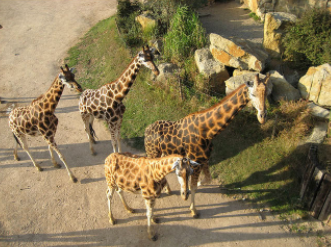

In [ ]:
from IPython.display import Image,display_png
display_png(Image('png/example.png'))

In [ ]:
!python sample.py --image="png/example.png"

<start> a group of giraffes standing next to each other . <end>


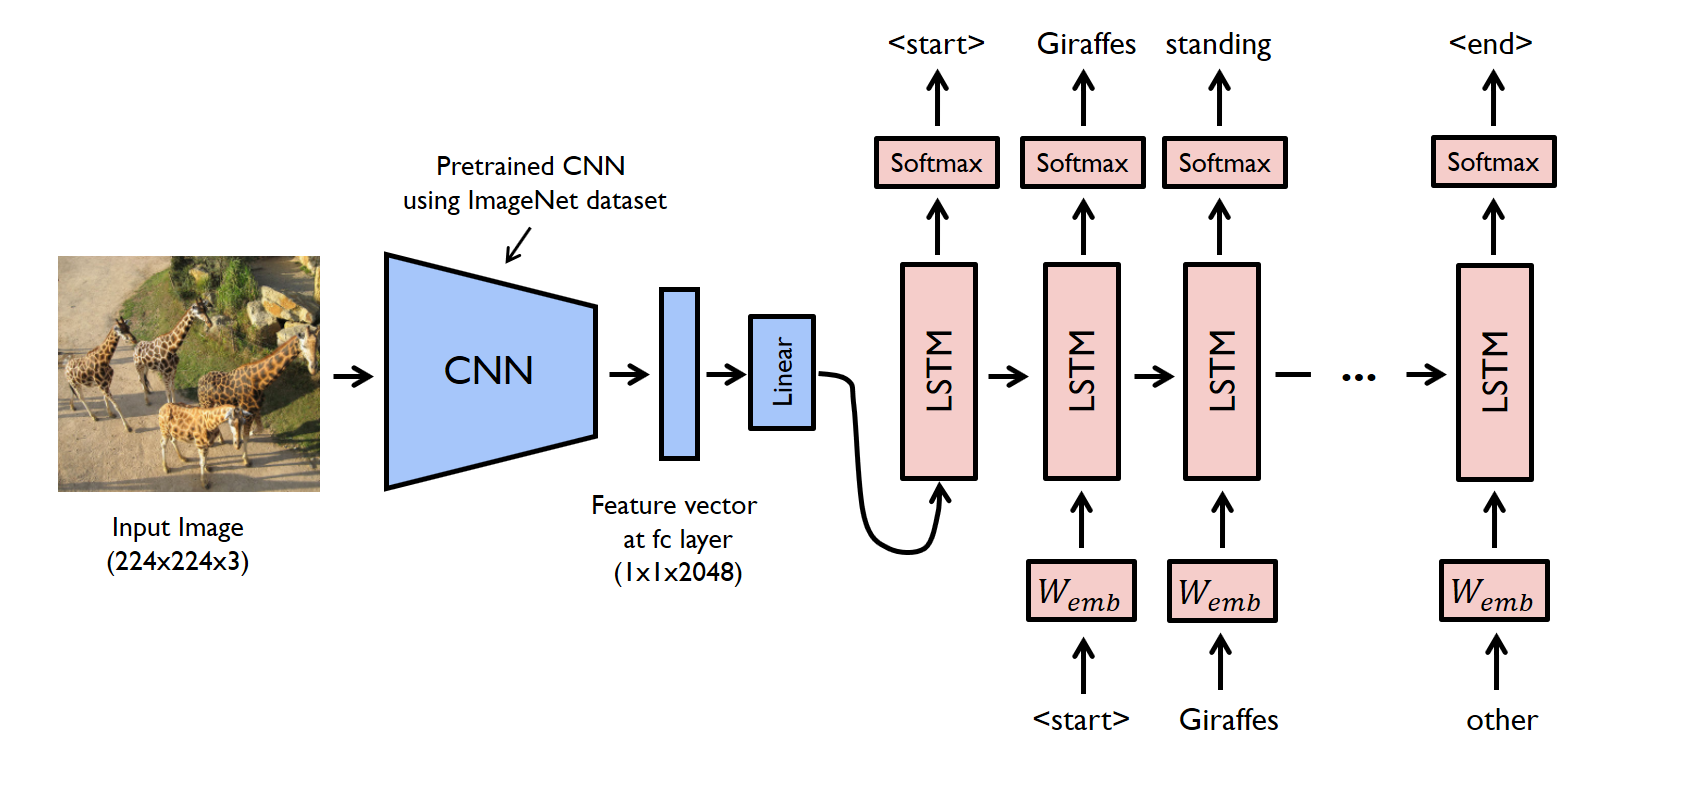

In [ ]:
from PIL import Image
!!curl -O http://www.manythings.org/anki/fra-eng.zip
!!unzip fra-eng.zip

Image.open('png/model.png')
#Image.open('png/example2.png')

In [ ]:
!python sample.py --image="png/example.png"

<start> a group of giraffes standing next to each other . <end>


## [Problem 3] Investigate what to do if you want to move with Keras

You can use pytorch2keras converter that has been already built, these are the steps provided in its readme 

https://github.com/gmalivenko/pytorch2keras

* You can convert by passing your model to pytorch_to_keras
* It will return a keras model that you can save as an h5 file and then convert it with tensorflowjs_converter but it doesn't work sometimes. As alternative, you may get Tensorflow Graph and save it as a frozen model.
* You will see the output layer name, so, now it's time to convert my_model.pb to tfjs model